In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Open ended reflections

## 1. Training Dynamics

### Is my model overfitting?

#### MLP

- **MLP Observations:**
    - The training loss steadily decreases, while the validation loss plateaus around epoch 5 and then stays flat (or increases slightly).
    - Validation F1 also plateaus early.
    - This divergence indicates potential overfitting (training loss improving while validation stalls), but the overall low performance also suggests that we might hvae hit a model capacity bottleneck (likely due to averaging embeddings and overall bad performance of an MLP model with only one hidden layer).

- **MLP Improvements:**
    - Currently we are using Dropout (0.3), stratified split. To reduce overfitting, we could add weight decay or add a LR scheduler. However, I don't think it's necessary to do much work on this oversimplified architecture. Moving on to a better model is a better choice

#### LSTM

- **LSTM Observations:**
    - Validation loss decreases steadily with training loss; gap between metrics is small.
    - Curve is jagged due to aggressive dropout but generalizaes well.

- **LSTM Success Factors:**
    - Aggressive dropout (0.5) on input, recurrent layers, and output.
    - Using layer norm stabilizes the embeddings, which in turn stabilizes training.
    - Weight Decay (6e-4) and LR scheduler prevent overfitting and help with convergence.


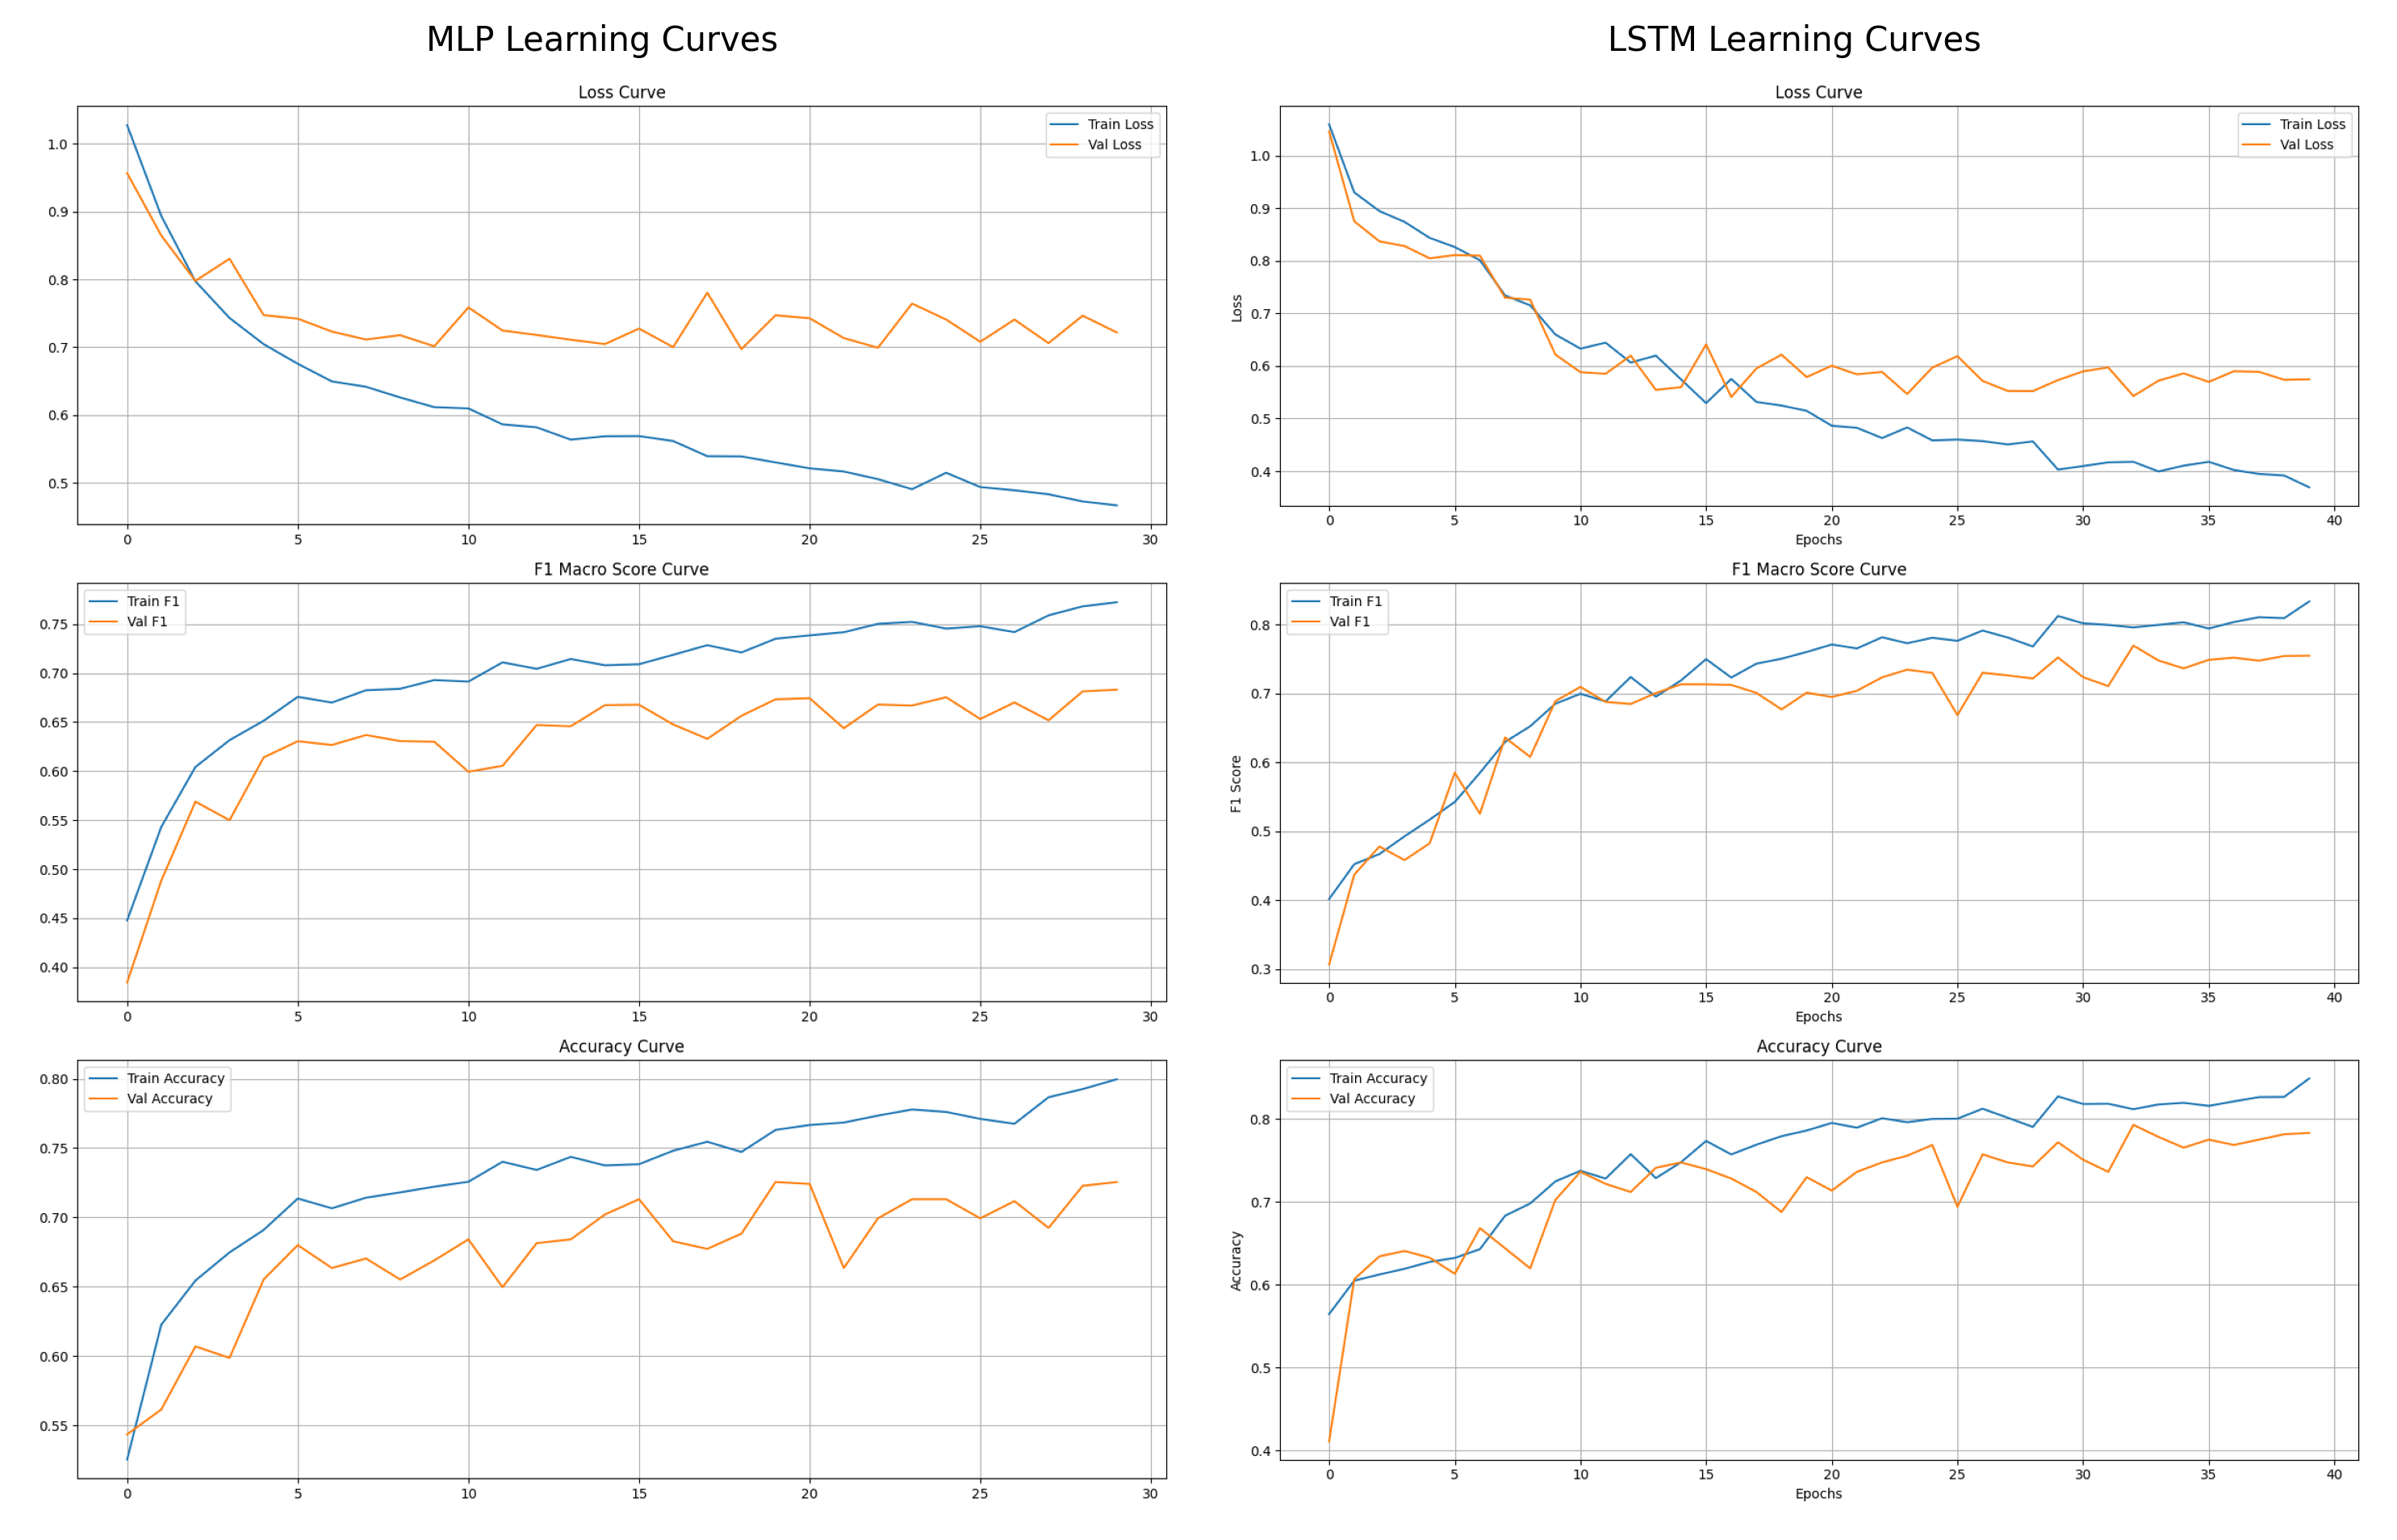

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,10), dpi=300)

img_mlp = mpimg.imread('../../outputs/mlp_f1_learning_curves.png')
img_lstm = mpimg.imread('../../outputs/lstm_f1_learning_curves.png')

ax[0].imshow(img_mlp)
ax[0].set_title('MLP Learning Curves', fontsize=10)
ax[0].axis('off')

ax[1].imshow(img_lstm)
ax[1].set_title('LSTM Learning Curves', fontsize=10)
ax[1].axis('off')

plt.tight_layout()
plt.show()

### How does the class weight affect the training process?

First, noting that the MLP model has significantly worse performance than LSTM (as discussed above), we will focus our analysis on the LSTM results to observe the impact of class weights.

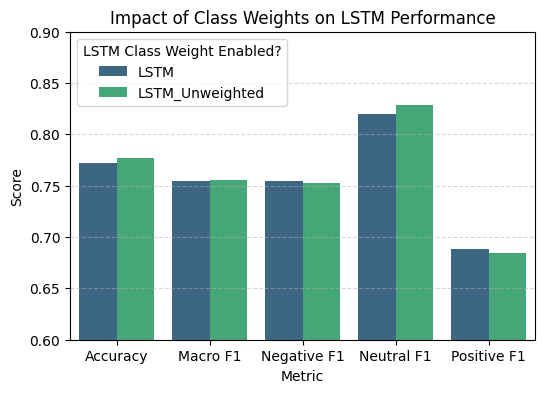

In [15]:
df = pd.read_csv('../../outputs/shared_metrics.csv')

# Filter for relevant models
models_to_compare = ['LSTM', 'LSTM_Unweighted']
df_filtered = df[df['Model'].isin(models_to_compare)].copy()

metrics = ['Accuracy', 'Macro F1', 'Negative F1', 'Neutral F1', 'Positive F1']
df_melted = df_filtered.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(6,4))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Impact of Class Weights on LSTM Performance')
plt.ylim(0.6, 0.9)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='LSTM Class Weight Enabled?')
plt.show()

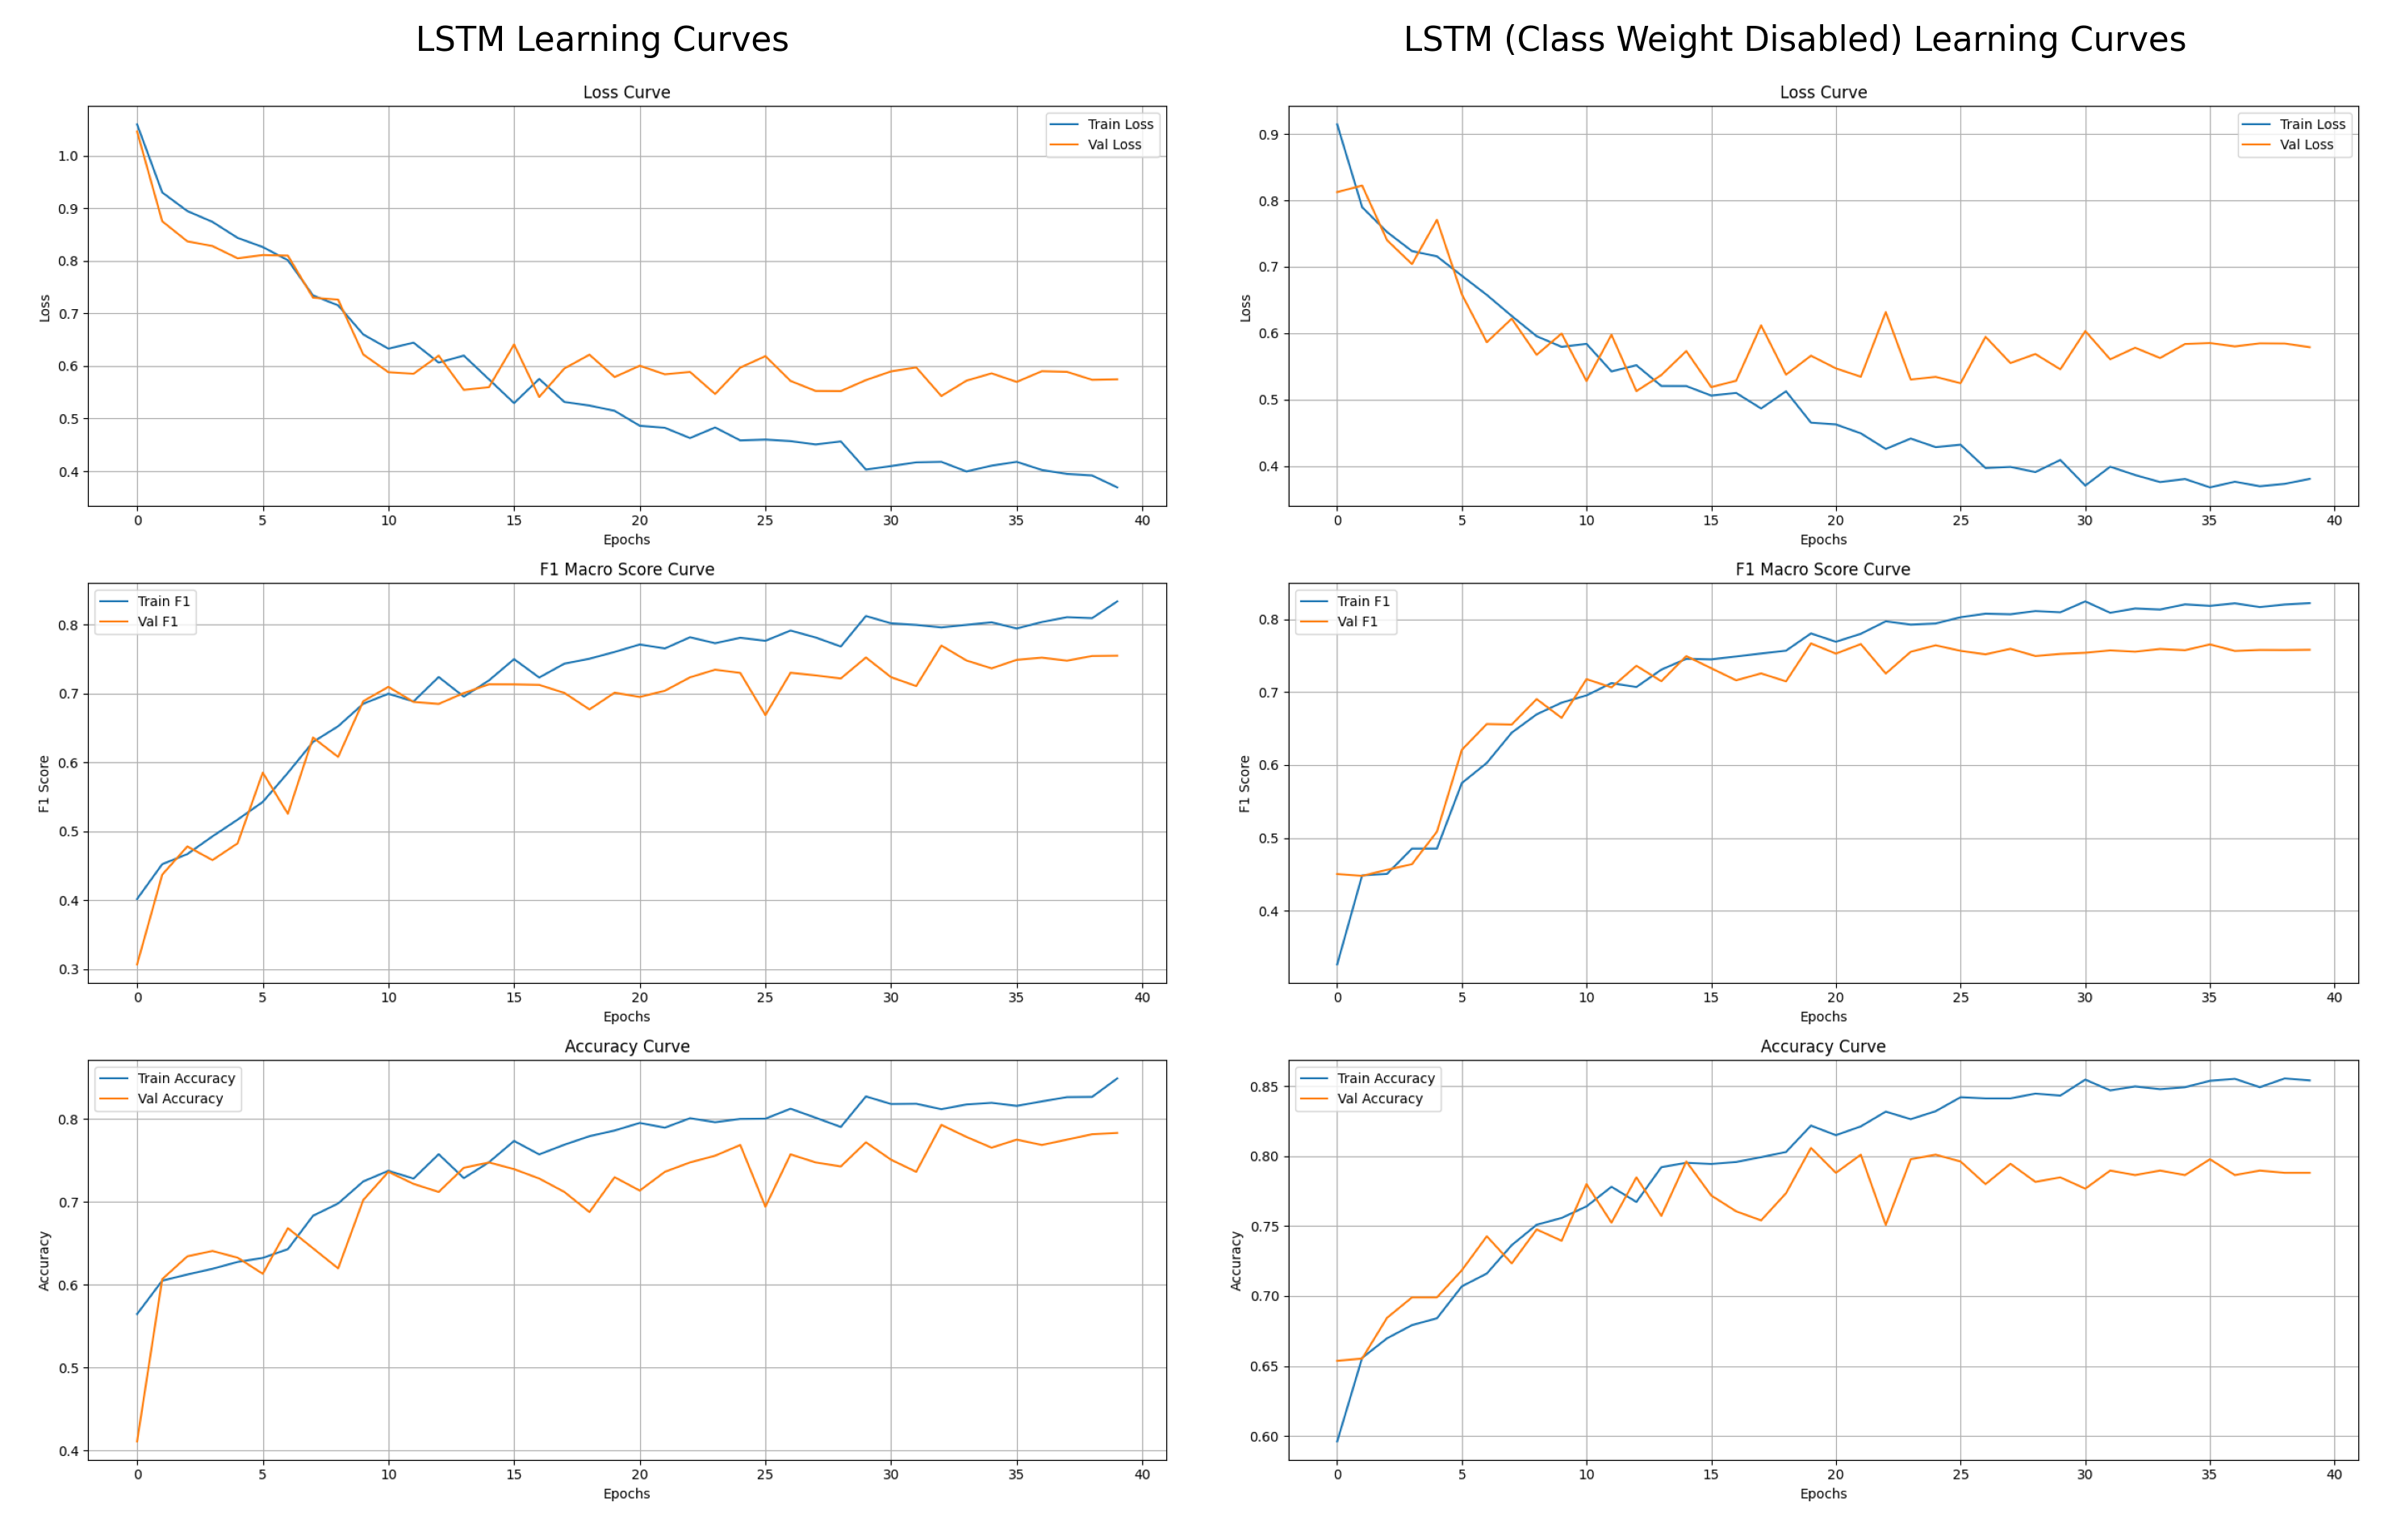

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(10,10), dpi=300)

img_unweighted = mpimg.imread('../../outputs/lstm_unweighted_f1_learning_curves.png')
img_lstm = mpimg.imread('../../outputs/lstm_f1_learning_curves.png')

ax[0].imshow(img_lstm)
ax[0].set_title('LSTM Learning Curves', fontsize=10)
ax[0].axis('off')

ax[1].imshow(img_unweighted)
ax[1].set_title('LSTM (Class Weight Disabled) Learning Curves', fontsize=10)
ax[1].axis('off')

plt.tight_layout()
plt.show()

- **Comparison of Weighted vs. Unweighted LSTM (Class weights):**
    - The Unweighted LSTM (F1: 0.755) actually performed very marginally better than the Weighted LSTM (F1: 0.754).
    - This is counterintuitive, as class weights are usually expected to help with imbalanced datasets (like our phrasebank)

- **Training Dynamics:**
    - The training characteristics were very similar between the two models.
    - Disabling class weights initially led to more early unstable loss characteristics.
    - However, as the scheduler set in and the Adam optimizer adapted, the loss curve became as smooth as, if not smoother than, the one with class weights.

## 2. Model Performance and Error Analysis

### Compare the generalization capabilities between MLP and LSTM

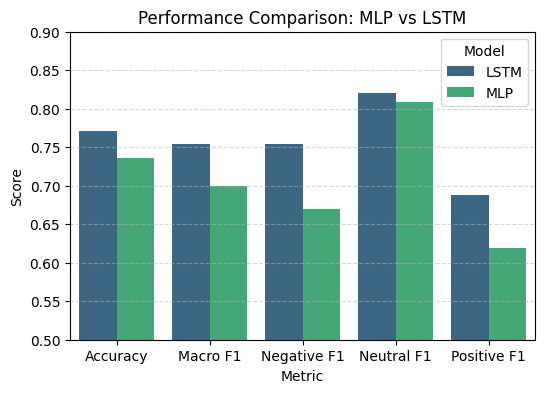

In [27]:
models_to_compare = ['MLP', 'LSTM']
df_filtered = df[df['Model'].isin(models_to_compare)].copy()

metrics = ['Accuracy', 'Macro F1', 'Negative F1', 'Neutral F1', 'Positive F1']
df_melted = df_filtered.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(6,4))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Performance Comparison: MLP vs LSTM')
plt.ylim(0.5, 0.9)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Model')
plt.show()

The LSTM significantly outperforms MLP across all metrics, particularly in Macro F1 and class-specific F1 scores.
This confirms that the recurrent architecture of the LSTM is much better suited for sequential text data than the simple MLP, which likely suffers from the loss of information due to embedding averaging.

### Which sentiment class was most frequently misclassified?

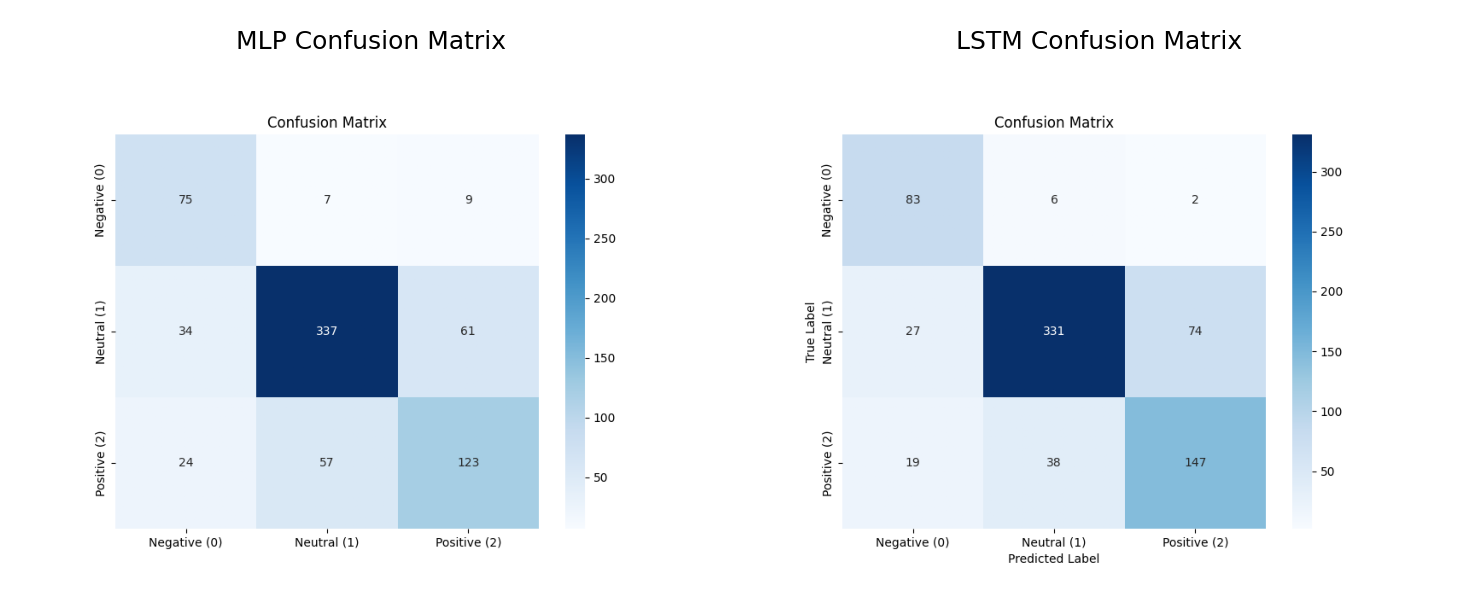

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(5,6), dpi=300)

# Load images
img_mlp = mpimg.imread('../../outputs/mlp_confusion_matrix.png')
img_lstm = mpimg.imread('../../outputs/lstm_confusion_matrix.png')

# Display MLP CM
ax[0].imshow(img_mlp)
ax[0].set_title('MLP Confusion Matrix', fontsize=6)
ax[0].axis('off')

# Display LSTM CM
ax[1].imshow(img_lstm)
ax[1].set_title('LSTM Confusion Matrix', fontsize=6)
ax[1].axis('off')

plt.tight_layout()
plt.show()

- **Positive Class Misclassification:**
    - The Positive class is the most frequently misclassified, consistently showing the lowest F1 score across models.
    - Reason: Positive sentiment in financial texts is often subtle or context-dependent (like "OpenAI debt increased" vs "IBM loss decreased"), making it harder to distinguish from neutral factual statements
    - The LSTM architecture (although I made it bidirectional) couldn't capture the context differences effectively, not to mention the much weaker MLP
- **Most Frequent Confusion:**
    - The confusion matrices confirm that Positive examples are most frequently mistaken for Neutral.
    - Reason: The lines between a "positive" financial outlook and a "neutral" financial report are often blurred. Many positive statements are phrased in a factual manner similar to neutral statements, causing the model to default to the majority class (neutral) when the signs are not clear enough

## 3. Cross-Model Comparison

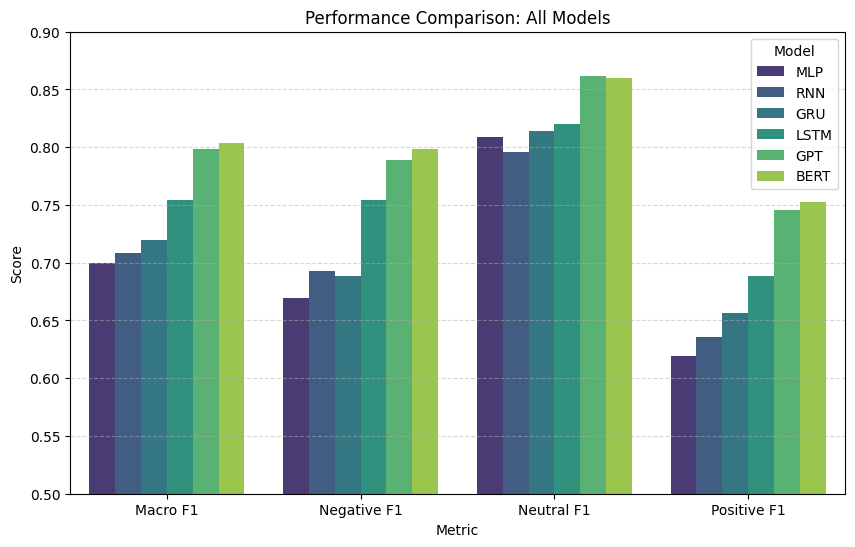

In [33]:
models_to_compare = ['MLP', 'RNN', 'GRU', 'LSTM', 'GPT', 'BERT']
df_filtered['Model'] = pd.Categorical(df_filtered['Model'], categories=models_to_compare, ordered=True)
df_filtered = df_filtered.sort_values('Model')

metrics = ['Macro F1', 'Negative F1', 'Neutral F1', 'Positive F1']
df_melted = df_filtered.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Model', palette='viridis')
plt.title('Performance Comparison: All Models')
plt.ylim(0.5, 0.9)
plt.ylabel('Score')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Model')
plt.show()

- **How did mean-pooled FastText embeddings limit the MLP compared to sequence-based models?**
    - Averaging all word embeddings into a single vector collapses the temporal structure and word order of the sentence, causing a massive loss of information. In contrast, sequence-based models constantly update their hidden state at each time step, allowing them to encode specific features and context much more effectively than a static average.
- **What advantage did the LSTM’s sequential processing provide over the MLP?**
    - The LSTM processes inputs token-by-token, updating its memory cell and hidden state at each step to selectively retain or forget information. This allows the final hidden state to effectively summarize the entire sequence's context and dependencies, whereas the MLP interacts with a static and collapsed representation that cannot distinguish between different arrangements of the same words.
- **Did fine-tuned LLMs (BERT/GPT) outperform classical baselines? Explain the performance gap in terms of pretraining and contextual representations.**
    - Yes, the fine-tuned LLMs significantly outperformed all classical baselines due to their massive parameter count and pretraining on enormous corpora, which allows them to understand nuanced language patterns. Furthermore, their attention mechanisms generate dynamic, contextualized embeddings for every token, providing a depth of understanding that static FastText embeddings cannot match.
- **Rank all six models by test performance. What architectural or representational factors explain the ranking?**
    - Tier 4: MLP (Lowest Performance). The simple averaging of embeddings destroys sequential information, leading to the worst performance among all models.
    - Tier 3: RNN. While better than the MLP due to sequential processing, the basic RNN struggles with vanishing gradients and has difficulty capturing long-term dependencies, limiting its effectiveness.
    - Tier 2: LSTM and GRU. Both models achieve great performance by using gating mechanisms to handle longer contexts and solve vanishing gradient issues; the LSTM's slightly higher complexity allows it to edge out the GRU in this specific task.
    - Tier 1: BERT and GPT (Highest Performance). Both transformer-based models are superior to all recurrent designs due to their pretraining and attention mechanisms; however, BERT slightly outperforms GPT for this classification task because its bidirectional encoder architecture is naturally better suited for understanding full sentence context than GPT's unidirectional decoder design.

## AI Use Disclosure (Required)

If you used any AI-enabled tools (e.g., ChatGPT, GitHub Copilot, Claude, or other LLM assistants) while working on this assignment, you must disclose that use here. The goal is transparency-not punishment.

In your disclosure, briefly include:
- **Tool(s) used:** (name + version if known)
- **How you used them:** (e.g., concept explanation, debugging, drafting code, rewriting text)
- **What you verified yourself:** (e.g., reran the notebook, checked outputs/plots, checked shapes, read documentation)
- **What you did *not* use AI for (if applicable):** (optional)

You are responsible for the correctness of your submission, even if AI suggested code or explanations.

#### <font color="red">Write your disclosure here.</font>

Gemini 3 Pro is used to help integrate the provided model validation scripts (the latter 100 lines to produce plots and metrics) with my own implementation of the mlp trainer script, in order to save time working out the visualizations. Some of the responses in this notebook is being paraphrased by Gemini 3 Flash. I provided a crude but detailed write-up, and Gemini refines it for me.